<a href="https://colab.research.google.com/github/StayFrostea/LearningML/blob/main/Roszell_Thesis_CT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading in the images from goodle drive

In [ ]:
## Loading the google drive where I stored the MOSMEDDATA files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Paths for the data

normal_path = '/content/drive/MyDrive/Colab Notebooks/Data/Keras CT'
abnormal_path = '/content/drive/MyDrive/Colab Notebooks/Data/Keras CT'

normal_path_output = '/content/drive/MyDrive/Colab Notebooks/Data/Keras CT/output'
abnormal_path_output = '/content/drive/MyDrive/Colab Notebooks/Data/Keras CT/output'
len(normal_path)

52

## Splitting the "files" into seperate 

In [ ]:
## A tool for spliting the image files before processing

!pip install split-folders 

In [ ]:
## Next up is to load the images into seperated folders
## I want 90% of them to be invoplved in the train/validate split
## Then I want 10% of them to never be touched by the model till I predict
## I want to also split them before I slice them down into 2d chunks

##import splitfolders

##splitfolders.ratio(normal_path, output=normal_path_output, seed=1337, ratio=(0.8, 0.2))
##splitfolders.ratio(abnormal_path, output=abnormal_path_output, seed=1337, ratio=(0.8, 0.2))

In [ ]:
## Check how many files got split up
import os

path, dirs, files = next(os.walk(abnormal_path_output + '/train/class1'))
file_count = len(files)
file_count

80

In [ ]:
## Check the second class has the same number of samples
path, dirs, files = next(os.walk(abnormal_path_output + '/train/class2'))
file_count = len(files)
file_count

80

## Now we are ready to load the files into the notebook as NifTi images

In [ ]:
import numpy as np
import nibabel as nib
from nibabel.testing import data_path
from scipy import ndimage

In [ ]:
## How to read in a NifTi file
def read_NifTi(fp):
    scan = nib.load(fp)
    scan = scan.get_fdata()
    return scan

In [ ]:
## Change the size of the volume to something which matches the input parameters
## of the pretrained model

def resizeVolume(img):

    ## desired
    d_depth = 64
    d_width = 150
    d_height = 150

    ## current
    c_depth = img.shape[-1]
    c_width = img.shape[0]
    c_height = img.shape[1]

    ## factor to change by
    d_factor = d_depth/c_depth
    w_factor = d_width/c_width
    h_factor = d_height/c_height

    ## Adjust proper rotation
    img = ndimage.rotate(img, 90, reshape = False)

    ## apply the factors
    img = ndimage.zoom(img, (w_factor, h_factor, d_factor), order = 1)

    return img

In [ ]:
## Normalize the pixel intensity to between 0 and 1
## Also change to float which is neccesary for th emodel

def normalizeVolume(vol):
    min = -1000
    max = 400
    vol[vol < min] = min
    vol[vol > max] = max
    vol = (vol - min) / (max - min)
    vol = vol.astype("float32")
    return vol

In [ ]:
def processVolume(path):
    volume = read_NifTi(path)
    volume = normalizeVolume(volume)
    volume = resizeVolume(volume)
    return volume

In [ ]:
normal_scan_paths = [
    os.path.join(os.getcwd(), normal_path_output + '/train/class1', x)
    for x in os.listdir(normal_path_output + '/train/class1')
]

abnormal_scan_paths = [
    os.path.join(os.getcwd(), normal_path_output + '/train/class2', x)
    for x in os.listdir(normal_path_output + '/train/class2')
]

In [ ]:
## Normal
normal_volumes = np.array([processVolume(path) for path in normal_scan_paths])
normal_volume_labels = np.array([0 for _ in range(len(normal_volumes))])

In [ ]:
## abNormal
abnormal_volumes = np.array([processVolume(path) for path in abnormal_scan_paths])
abnormal_volume_labels = np.array([1 for _ in range(len(abnormal_volumes))])

In [ ]:
print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))

## Now we can split the images into training and validation in order to train the model

In [ ]:
## Example way
## The [:60] means up to index 60
## Therefore we will have a 60/20 split for train/val
X_train = np.concatenate((abnormal_volumes[:60], normal_volumes[:60]), axis=0)
y_train = np.concatenate((abnormal_volume_labels[:60], normal_volume_labels[:60]), axis=0)

X_val = np.concatenate((abnormal_volumes[60:], normal_volumes[60:]), axis=0)
y_val = np.concatenate((abnormal_volume_labels[60:], normal_volume_labels[60:]), axis=0)

print( 
    
"Number of samples in train and validation are %d and %d."
    % (X_train.shape[0], X_val.shape[0])
)
X_train.shape

Number of samples in train and validation are 120 and 40.


(120, 150, 150, 64)

## This is where I will put preprocessing.

In [ ]:
import random
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

## Some augmentation by rotation

def rotate(volume):

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


## We rotate at random to remove the orientation effect on the model
## Also we have stacked three of the same image into the 2nd dimension to fit
## the imagenet input parameters
def train_preprocess(volume, label):
  volume = rotate(volume)
  volume = tf.stack((volume,)*3, axis = 3)
  return volume, label

## No need to rotate the validation set
def valid_preprocess(volume, label):
  volume = tf.stack((volume,)*3, axis = 3)
  return volume, label

In [ ]:
## Using the functions without Dataset
X_train_r, y_train_r = train_preprocess(X_train, y_train)
X_val_r, y_val_r = valid_preprocess(X_val, y_train)
y_train_r.shape

(120,)

## Using tensorflows automated data loaders

## Skipping this for now

In [ ]:
# ## Use a library called tf.data.Dataset.from_tensor_slice
# ## This will cut it into appropriate 2D slices and contain them in an array of 2d slices

# train_loader = tf.data.Dataset.from_tensor_slices((X_train,y_train))

# valid_loader = tf.data.Dataset.from_tensor_slices((X_val,y_val))

In [ ]:
# import tensorflow_datasets as tfds

# ## This is constructing the dataset to be passed into the model 
# ## for training and validation
# batch_size = 1

# train_dataset = (
#     train_loader.shuffle(len(X_train))
#     .map(train_preprocess)
#     .batch(batch_size)
#     .prefetch(1)
# )

# validation_dataset = (
#     valid_loader.shuffle(len(X_val))
#     .map(valid_preprocess)
#     .batch(batch_size)
#     .prefetch(1)
# )

In [ ]:
X_train_r.shape

In [ ]:
X_val_r.shape

## Working 3D volumes into 2D Image Array

In [ ]:
def threeDToTwoD(threeDVol, numVol):

  twoDVol = np.zeros((numVol*64, 150, 150, 3), np.float32)

  count = 0

  for i in range(numVol):
    for j in range(64):
      twoDVol[count] = threeDVol[i,:,:,:,j]
      count = count + 1

  return twoDVol

In [ ]:
X_train_f = threeDToTwoD(X_train_r, 120)

In [ ]:
X_train_f.shape

(7680, 150, 150, 3)

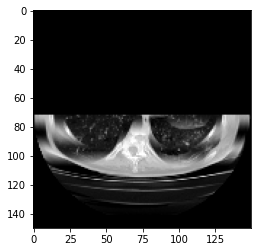

In [ ]:
import matplotlib.pyplot as plt

## Person 0 @ 1/3 through

image = X_train_f[20]
plt.imshow(np.squeeze(image[:,:,1]), cmap ="gray")

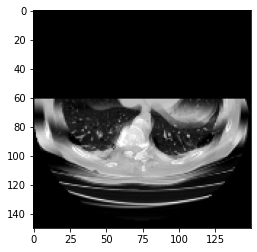

In [ ]:
## Person 1 @ 1/3 through
image = X_train_f[84]
plt.imshow(np.squeeze(image[:,:,1]), cmap ="gray")

In [ ]:
## Now the validation volumes
X_val_f = threeDToTwoD(X_val_r, 40)

In [ ]:
def extendLabels(labelArr, numVol):

  newLabelArr = np.zeros((numVol * 64), np.float32)

  for i in range(numVol):
    for j in range(64):
      newLabelArr[(i*64)+j] = labelArr[i]

  return newLabelArr

In [ ]:
## Now the labels
y_train_f = extendLabels(y_train_r, 120)
y_val_f = extendLabels(y_val_r, 40)

In [ ]:
y_train_f.shape

(7680,)

(7680,)

In [ ]:
print(y_train_f[0], y_train_f[63], y_train_f[4112], y_train_f[4121])

1.0 1.0 0.0 0.0


## Finally the model

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
import matplotlib.pyplot as plt

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

In [ ]:
def buildModel():

  initial_model = tf.keras.applications.Xception(
      weights = 'imagenet',
      input_shape = (150,150,3),
      include_top = False)
  
  ## Freeze the pretrained model parameters
  initial_model.trainable = False

  inputs = tf.keras.Input(shape = (150,150,3))

  x = data_augmentation(inputs)

  scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
  x = scale_layer(x)

  x = initial_model(inputs, training = False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  model = tf.keras.Model(inputs, outputs)
  return model

model = buildModel()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
## Setting up the fit parameters
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.0001, decay_steps=100000, decay_rate=0.96, staircase=True
)

model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              metrics = tf.keras.metrics.BinaryAccuracy(),
              )

## Defining 
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "3D_CT_classification.h5", save_best_only=True
)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

## How man runs
epochs = 20

In [ ]:
## Take the multiple 2D Ct images from each photo and add them into the same 
## dataset

model.fit(x = X_train_f,
          y = y_train_f,
          validation_data=(X_val_f, y_val_f),
          epochs=epochs,
          shuffle=True,
          verbose='auto',
          callbacks = [ checkpoint_cb , early_stopping_cb],
          )

Epoch 1/20
240/240 [==============================] - 75s 181ms/step - loss: 0.6718 - binary_accuracy: 0.5892 - val_loss: 0.6083 - val_binary_accuracy: 0.6648


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
240/240 [==============================] - 42s 175ms/step - loss: 0.6061 - binary_accuracy: 0.6921 - val_loss: 0.5946 - val_binary_accuracy: 0.6898
Epoch 3/20
240/240 [==============================] - 42s 173ms/step - loss: 0.5664 - binary_accuracy: 0.7332 - val_loss: 0.6276 - val_binary_accuracy: 0.6578
Epoch 4/20
240/240 [==============================] - 42s 175ms/step - loss: 0.5384 - binary_accuracy: 0.7523 - val_loss: 0.7412 - val_binary_accuracy: 0.5656
Epoch 5/20
240/240 [==============================] - 42s 174ms/step - loss: 0.5160 - binary_accuracy: 0.7676 - val_loss: 0.7008 - val_binary_accuracy: 0.6141
Epoch 6/20
240/240 [==============================] - 42s 174ms/step - loss: 0.4974 - binary_accuracy: 0.7818 - val_loss: 0.7958 - val_binary_accuracy: 0.5395
Epoch 7/20
240/240 [==============================] - 42s 174ms/step - loss: 0.4813 - binary_accuracy: 0.7923 - val_loss: 0.8571 - val_binary_accuracy: 0.4996
Epoch 8/20
240/240 [==========================

## Next Steps

In [ ]:
## Transfer to MRI notebook
## Get it to work
## Remove Preprocessing
## Introduce Graphics for Results
## Predict

## The input size can be bigger than what the pretrained model is
## Slices can get rid of the "non-data"

In [ ]:
# ## Retraining after unfreezing base model
# initial_model.trainable = True
# model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
#               optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
#               metrics = keras.metrics.BinaryAccuracy(),
#               )

# ## Only need to train one layer so less epochs
# epochs = 10

# model.fit(train_dataset,
#           validation_data=validation_dataset,
#           epochs=epochs,
#           shuffle=True,
#           verbose='auto',
#           callbacks = [ checkpoint_cb , early_stopping_cb],
#           )